In [ ]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_compilation_cache_dir", "./jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
# os.environ["XLA_FLAGS"] = (
#     "--xla_disable_hlo_passes=constant_folding "  # this disables constant folding
#     # "--xla_cpu_use_thunk_runtime=false "
# )
from desc import set_device
set_device("gpu")

In [2]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_explain_cache_misses", True)

In [3]:
# from desc import set_device, _set_cpu_count

# num_device = 2
# _set_cpu_count(num_device)
# set_device("cpu", num_device=num_device)

In [4]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [5]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *
from desc.io import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.16.0+15.g1dde9c2c6.dirty.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 11.17 GB available memory.


In [27]:
eq = desc.examples.get("HELIOTRON")
eq.change_resolution(1, 1, 1, 2, 2, 2)
eq1 = eq.copy()
eq2 = eq.copy()
con1 = ObjectiveFunction(ForceBalance(eq1), use_jit=False)
obj1 = ObjectiveFunction(
    (
        QuasisymmetryTripleProduct(eq1, deriv_mode="fwd"),
        AspectRatio(eq1, deriv_mode="fwd"),
        Volume(eq1, deriv_mode="fwd"),
    ),
    deriv_mode="batched",
    use_jit=False,
)
con2 = ObjectiveFunction(ForceBalance(eq2), use_jit=False)
obj2 = ObjectiveFunction(
    (
        QuasisymmetryTripleProduct(eq2, deriv_mode="fwd"),
        AspectRatio(eq2, deriv_mode="fwd"),
        Volume(eq2, deriv_mode="fwd"),
    ),
    deriv_mode="batched",
    use_jit=False,
)
perturb_options = {"order": 1}
solve_options = {"maxiter": 1}

# test different inversion methods give same result
# Note: svd-reg is expected to be different due to regularization
prox_qr = ProximalProjection(
    obj1, con1, eq1, perturb_options, solve_options, inv_method="qr"
)
prox_svd = ProximalProjection(
    obj2, con2, eq2, perturb_options, solve_options, inv_method="svd"
)
prox_qr.build()
prox_svd.build()

/CODES/DESC/desc/utils.py:572: UserWarning: Reducing radial (L) resolution can make plasma boundary inconsistent. Recommend calling `eq.surface = eq.get_surface_at(rho=1.0)`
  warnings.warn(msg, err)


Building objective: QS triple product
Precomputing transforms
Building objective: aspect ratio
Precomputing transforms
Building objective: volume
Precomputing transforms
Building objective: force
Precomputing transforms
Building objective: QS triple product
Precomputing transforms
Building objective: aspect ratio
Precomputing transforms
Building objective: volume
Precomputing transforms
Building objective: force
Precomputing transforms


In [28]:
x = prox_qr.x(eq)
jac_qr = prox_qr.jac_scaled(x)
jac_svd = prox_svd.jac_scaled(x)

In [33]:
np.testing.assert_allclose(jac_qr, jac_svd, rtol=1e-12, atol=1e-12)

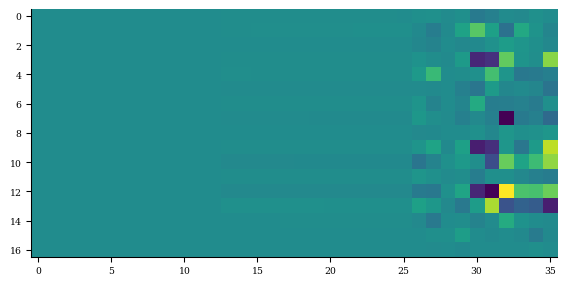

In [30]:
plt.imshow(jac_qr)

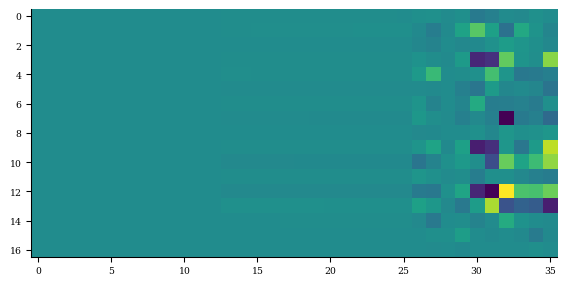

In [31]:
plt.imshow(jac_svd)

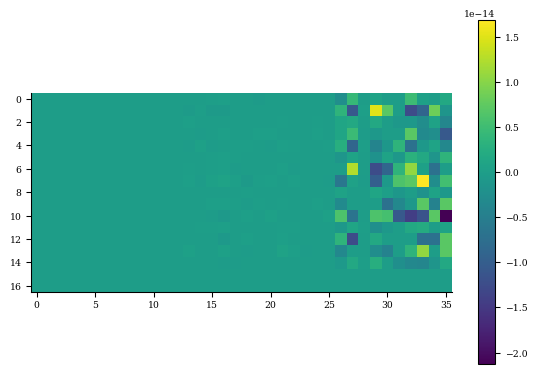

In [32]:
plt.imshow(jac_svd-jac_qr)
plt.colorbar()